<a href="https://colab.research.google.com/github/ykitaguchi77/GravCont_classification_colab/blob/master/EfficientNet_age_sex_crossvalidation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


#**Evaluator**

In [2]:
import os
import random
import numpy as np
import glob
import torch
from torch.utils.data import Dataset
from PIL import Image
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

class Evaluator:
    def __init__(self, model, classes, age_dict, sex_dict, val_folder_path, val_transform, device, print_round_num=2) -> None:
        super().__init__()
        self.model = model
        self.val_folder_path = val_folder_path
        self.val_transform = val_transform
        self.device = device
        self.print_round_num = print_round_num
        
        self.class_names = classes
        self.age_dict = age_dict
        self.sex_dict = sex_dict
        self.image_paths = glob.glob(self.val_folder_path + "/*/*")
        print('eval number of classes: ' +str(len(self.class_names)))
        print('eval number of images: ' +str(len(self.image_paths)))
        random.shuffle(self.image_paths) 

        self.max_accuracy = 0
        # to update self.max_accuracy
        self.evaluate()
        print("initial accuracy: " + str(self.max_accuracy))

    def evaluate(self):
        TP = FP = TN = FN = TP = FP = TN = FN = 0
        image_name_list = []
        label_list = []
        model_pred_list = []

        model_pred_class = []
        model_pred_prob = []

        for image_path in self.image_paths:
            image_name, label, age, sex = self.get_label(image_path)
            if np.isnan(age):
                    continue
            image_tensor = self.get_image_tensor(image_path)

            is_training = self.model.training
            self.model.eval()
            with torch.no_grad():
                output = self.model(image_tensor)
            if is_training:
                self.model.train()
                
            output = output.squeeze(0)
            #model_pred:クラス名前、prob:確率、pred:クラス番号
            prob = torch.clamp(output[0], 0, 1)
            pred = int(torch.round(prob))
            model_pred = self.class_names[pred]
            
            image_name_list.append(image_name)
            label_list.append(label)
            model_pred_list.append(model_pred)

            model_pred_class.append(int(pred))
            model_pred_prob.append(float(prob))

            if label == self.class_names[0]:
                if model_pred == self.class_names[0]:
                    TN += 1
                else:
                    FP += 1
            elif label == self.class_names[1]:
                if model_pred == self.class_names[1]:
                    TP += 1
                else:
                    FN += 1

        accuracy, precision, recall, specificity, f_value = self.calculate_accuracy(TP, TN, FP, FN)
        is_best = self.max_accuracy < accuracy
        if is_best:
            self.max_accuracy = accuracy

        return is_best, (round(accuracy, self.print_round_num), 
            round(precision, self.print_round_num), 
            round(recall, self.print_round_num), 
            round(specificity, self.print_round_num), 
            round(f_value, self.print_round_num))
        
    def draw_roc(self, output_path):
        label_list = []
        model_pred_prob = []

        for image_path in self.image_paths:
            image_name, label, age, sex = self.get_label(image_path)
            image_tensor = self.get_image_tensor(image_path)

            is_training = self.model.training
            self.model.eval()
            with torch.no_grad():
                output = self.model(image_tensor)
            if is_training:
                self.model.train()
                
            output = output.squeeze(0)
            #model_pred:クラス名前、prob:確率、pred:クラス番号
            prob = torch.clamp(output[0], 0, 1)

            label_list.append(label)
            model_pred_prob.append(float(prob))

        y_score = []
        y_true = []

        k=0
        for i in label_list:
            if label_list[k] == 'cont':
                y_true.append(0)
            elif label_list[k] == 'grav':
                y_true.append(1)
            k+=1

        #健康な状態を「0」、病気を「1」としてラベルよりリストを作成
        y_true = y_true
        #それぞれの画像における陽性の確率についてリストを作成
        y_score = model_pred_prob
        try:
            fpr, tpr, thred = roc_curve(y_true, y_score)
            roc_auc = auc(fpr, tpr)

            plt.figure()
            lw = 2
            plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
            plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver operating characteristic example')
            plt.legend(loc="lower right")
            plt.savefig(output_path)
        except:
            pass

    #対象のパスからラベルを抜き出す
    def get_label(self, image_path):
        image_name = os.path.basename(image_path)
        
        base_name, ext = os.path.splitext(image_name)
        age = float(self.age_dict[base_name]) / 100
        sex = float(self.sex_dict[base_name])
        
        label = os.path.basename(os.path.dirname(image_path))
        return(image_name, label, age, sex)
        
    def get_image_tensor(self, image_path):    
        image = Image.open(image_path).convert("RGB")
        image_tensor = self.val_transform(image)
        image_tensor.unsqueeze_(0)
        image_tensor = image_tensor.to(self.device) 
        return(image_tensor)
        
    def calculate_accuracy(self, TP, TN, FP, FN):
        try:
            accuracy = (TP + TN)/ (TP + TN + FP + FN)
            precision  = TP/(FP + TP)
            recall = TP/(TP + FN)
            specificity = TN/(FP + TN)
            f_value = (2*recall*precision)/(recall+precision)
        except:
            accuracy = -1
            precision  = -1
            recall = -1
            specificity = -1
            f_value = -1
        return(accuracy, precision, recall, specificity, f_value)

#**Train**

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-cp36-none-any.whl size=16032 sha256=14cdeb2ef8760e3e04567980dd337e619641682c94a81a3aac8e782f71d38e8a
  Stored in directory: /root/.cache/pip/wheels/e9/c6/e1/7a808b26406239712cfce4b5ceeb67d9513ae32aa4b31445c6
Successfully built efficientnet-pytorch


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth



Loaded pretrained weights for efficientnet-b0
train_dataset_size：463
eval number of classes: 2
eval number of images: 116
initial accuracy: 0


  0%|          | 0/100 [00:00<?, ?it/s]

-----
(-1, -1, -1, -1, -1)
max_accuracy: 0
-----
(-1, -1, -1, -1, -1)
max_accuracy: 0
-----
(0.53, 1.0, 0.07, 1.0, 0.13)
max_accuracy: 0.5344827586206896


  1%|          | 1/100 [01:33<2:34:20, 93.54s/it]

-----
(0.57, 0.75, 0.21, 0.93, 0.32)
max_accuracy: 0.5689655172413793
-----
(0.62, 0.82, 0.31, 0.93, 0.45)
max_accuracy: 0.6206896551724138
-----
(0.59, 0.78, 0.24, 0.93, 0.37)
max_accuracy: 0.6206896551724138


  2%|▏         | 2/100 [01:52<1:56:16, 71.18s/it]

-----
(0.6, 0.8, 0.28, 0.93, 0.41)
max_accuracy: 0.6206896551724138
-----
(0.58, 0.74, 0.24, 0.91, 0.36)
max_accuracy: 0.6206896551724138
-----
(0.58, 0.74, 0.24, 0.91, 0.36)
max_accuracy: 0.6206896551724138


  3%|▎         | 3/100 [02:06<1:27:19, 54.02s/it]

-----
(0.65, 0.79, 0.4, 0.9, 0.53)
max_accuracy: 0.646551724137931
-----
(0.62, 0.72, 0.4, 0.84, 0.51)
max_accuracy: 0.646551724137931
-----
(0.67, 0.81, 0.45, 0.9, 0.58)
max_accuracy: 0.6724137931034483


  4%|▍         | 4/100 [02:25<1:09:24, 43.38s/it]

-----
(0.67, 0.81, 0.45, 0.9, 0.58)
max_accuracy: 0.6724137931034483
-----
(0.61, 0.78, 0.31, 0.91, 0.44)
max_accuracy: 0.6724137931034483
-----
(0.66, 0.76, 0.48, 0.84, 0.59)
max_accuracy: 0.6724137931034483


  5%|▌         | 5/100 [02:39<54:44, 34.58s/it]  

-----
(0.65, 0.77, 0.41, 0.88, 0.54)
max_accuracy: 0.6724137931034483
-----
(0.61, 0.74, 0.34, 0.88, 0.47)
max_accuracy: 0.6724137931034483
-----
(0.68, 0.77, 0.52, 0.84, 0.62)
max_accuracy: 0.6810344827586207


  6%|▌         | 6/100 [02:55<45:32, 29.07s/it]

-----
(0.75, 0.76, 0.72, 0.78, 0.74)
max_accuracy: 0.75
-----
(0.74, 0.79, 0.66, 0.83, 0.72)
max_accuracy: 0.75
-----
(0.76, 0.79, 0.71, 0.81, 0.75)
max_accuracy: 0.7586206896551724


  7%|▋         | 7/100 [03:14<40:21, 26.03s/it]

-----
(0.67, 0.78, 0.48, 0.86, 0.6)
max_accuracy: 0.7586206896551724
-----
(0.68, 0.69, 0.66, 0.71, 0.67)
max_accuracy: 0.7586206896551724
-----
(0.73, 0.69, 0.84, 0.62, 0.76)
max_accuracy: 0.7586206896551724


  8%|▊         | 8/100 [03:28<34:22, 22.42s/it]

-----
(0.72, 0.73, 0.69, 0.74, 0.71)
max_accuracy: 0.7586206896551724
-----
(0.74, 0.73, 0.76, 0.72, 0.75)
max_accuracy: 0.7586206896551724
-----
(0.73, 0.8, 0.62, 0.84, 0.7)
max_accuracy: 0.7586206896551724


  9%|▉         | 9/100 [03:42<30:08, 19.88s/it]

-----
(0.71, 0.65, 0.88, 0.53, 0.75)
max_accuracy: 0.7586206896551724
-----
(0.72, 0.68, 0.86, 0.59, 0.76)
max_accuracy: 0.7586206896551724
-----
(0.78, 0.76, 0.81, 0.74, 0.78)
max_accuracy: 0.7758620689655172


 10%|█         | 10/100 [03:58<28:11, 18.79s/it]

-----
(0.72, 0.66, 0.88, 0.55, 0.76)
max_accuracy: 0.7758620689655172
-----
(0.77, 0.74, 0.83, 0.71, 0.78)
max_accuracy: 0.7758620689655172
-----
(0.75, 0.75, 0.74, 0.76, 0.75)
max_accuracy: 0.7758620689655172


 11%|█         | 11/100 [04:12<25:45, 17.37s/it]

-----
(0.77, 0.75, 0.79, 0.74, 0.77)
max_accuracy: 0.7758620689655172
-----
(0.75, 0.72, 0.81, 0.69, 0.76)
max_accuracy: 0.7758620689655172
-----
(0.73, 0.69, 0.84, 0.62, 0.76)
max_accuracy: 0.7758620689655172


 12%|█▏        | 12/100 [04:26<23:59, 16.36s/it]

-----
(0.7, 0.68, 0.74, 0.66, 0.71)
max_accuracy: 0.7758620689655172
-----
(0.72, 0.68, 0.81, 0.62, 0.74)
max_accuracy: 0.7758620689655172
-----
(0.65, 0.72, 0.48, 0.81, 0.58)
max_accuracy: 0.7758620689655172


 13%|█▎        | 13/100 [04:40<22:40, 15.64s/it]

-----
(0.75, 0.72, 0.83, 0.67, 0.77)
max_accuracy: 0.7758620689655172
-----
(0.72, 0.66, 0.88, 0.55, 0.76)
max_accuracy: 0.7758620689655172
-----
(0.71, 0.65, 0.88, 0.53, 0.75)
max_accuracy: 0.7758620689655172


 14%|█▍        | 14/100 [04:54<21:41, 15.13s/it]

-----
(0.68, 0.62, 0.93, 0.43, 0.74)
max_accuracy: 0.7758620689655172
-----
(0.73, 0.68, 0.88, 0.59, 0.77)
max_accuracy: 0.7758620689655172
-----
(0.75, 0.72, 0.83, 0.67, 0.77)
max_accuracy: 0.7758620689655172


 15%|█▌        | 15/100 [05:08<20:55, 14.77s/it]

-----
(0.67, 0.62, 0.9, 0.45, 0.73)
max_accuracy: 0.7758620689655172
-----
(0.65, 0.6, 0.84, 0.45, 0.71)
max_accuracy: 0.7758620689655172
-----
(0.66, 0.61, 0.88, 0.43, 0.72)
max_accuracy: 0.7758620689655172


 16%|█▌        | 16/100 [05:22<20:23, 14.56s/it]

-----
(0.66, 0.61, 0.88, 0.45, 0.72)
max_accuracy: 0.7758620689655172
-----
(0.75, 0.73, 0.79, 0.71, 0.76)
max_accuracy: 0.7758620689655172
-----
(0.72, 0.67, 0.9, 0.55, 0.76)
max_accuracy: 0.7758620689655172


 17%|█▋        | 17/100 [05:36<19:54, 14.39s/it]

-----
(0.73, 0.7, 0.81, 0.66, 0.75)
max_accuracy: 0.7758620689655172
-----
(0.72, 0.73, 0.69, 0.74, 0.71)
max_accuracy: 0.7758620689655172
-----
(0.76, 0.73, 0.81, 0.71, 0.77)
max_accuracy: 0.7758620689655172


 18%|█▊        | 18/100 [05:50<19:30, 14.27s/it]

-----
(0.71, 0.65, 0.91, 0.5, 0.76)
max_accuracy: 0.7758620689655172
-----
(0.75, 0.72, 0.81, 0.69, 0.76)
max_accuracy: 0.7758620689655172
-----
(0.76, 0.76, 0.76, 0.76, 0.76)
max_accuracy: 0.7758620689655172


 19%|█▉        | 19/100 [06:04<19:05, 14.14s/it]

-----
(0.68, 0.62, 0.91, 0.45, 0.74)
max_accuracy: 0.7758620689655172
-----
(0.78, 0.76, 0.81, 0.74, 0.78)
max_accuracy: 0.7758620689655172
-----
(0.76, 0.75, 0.78, 0.74, 0.76)
max_accuracy: 0.7758620689655172


 20%|██        | 20/100 [06:18<18:45, 14.07s/it]

-----
(0.7, 0.65, 0.84, 0.55, 0.74)
max_accuracy: 0.7758620689655172
-----
(0.7, 0.68, 0.76, 0.64, 0.72)
max_accuracy: 0.7758620689655172
-----
(0.72, 0.74, 0.67, 0.76, 0.7)
max_accuracy: 0.7758620689655172


 21%|██        | 21/100 [06:32<18:30, 14.05s/it]

-----
(0.78, 0.74, 0.84, 0.71, 0.79)
max_accuracy: 0.7758620689655172
-----
(0.7, 0.66, 0.81, 0.59, 0.73)
max_accuracy: 0.7758620689655172
-----
(0.73, 0.69, 0.84, 0.62, 0.76)
max_accuracy: 0.7758620689655172


 22%|██▏       | 22/100 [06:46<18:17, 14.06s/it]

-----
(0.73, 0.68, 0.88, 0.59, 0.77)
max_accuracy: 0.7758620689655172
-----
(0.78, 0.74, 0.84, 0.71, 0.79)
max_accuracy: 0.7758620689655172
-----
(0.73, 0.75, 0.71, 0.76, 0.73)
max_accuracy: 0.7758620689655172


 23%|██▎       | 23/100 [07:00<18:00, 14.03s/it]

-----
(0.73, 0.74, 0.72, 0.74, 0.73)
max_accuracy: 0.7758620689655172
-----
(0.77, 0.73, 0.84, 0.69, 0.78)
max_accuracy: 0.7758620689655172
-----
(0.74, 0.73, 0.76, 0.72, 0.75)
max_accuracy: 0.7758620689655172


 24%|██▍       | 24/100 [07:14<17:47, 14.05s/it]

-----
(0.72, 0.72, 0.72, 0.72, 0.72)
max_accuracy: 0.7758620689655172
-----
(0.72, 0.69, 0.78, 0.66, 0.73)
max_accuracy: 0.7758620689655172
-----
(0.75, 0.74, 0.78, 0.72, 0.76)
max_accuracy: 0.7758620689655172


 25%|██▌       | 25/100 [07:28<17:32, 14.03s/it]

-----
(0.72, 0.66, 0.91, 0.53, 0.77)
max_accuracy: 0.7758620689655172
-----
(0.69, 0.64, 0.88, 0.5, 0.74)
max_accuracy: 0.7758620689655172
-----
(0.73, 0.79, 0.64, 0.83, 0.7)
max_accuracy: 0.7758620689655172


 26%|██▌       | 26/100 [07:42<17:16, 14.01s/it]

-----
(0.7, 0.68, 0.74, 0.66, 0.71)
max_accuracy: 0.7758620689655172
-----
(0.71, 0.69, 0.74, 0.67, 0.72)
max_accuracy: 0.7758620689655172
-----
(0.72, 0.66, 0.88, 0.55, 0.76)
max_accuracy: 0.7758620689655172


 27%|██▋       | 27/100 [07:56<17:00, 13.97s/it]

-----
(0.76, 0.71, 0.88, 0.64, 0.78)
max_accuracy: 0.7758620689655172
-----
(0.75, 0.72, 0.81, 0.69, 0.76)
max_accuracy: 0.7758620689655172
-----
(0.72, 0.69, 0.83, 0.62, 0.75)
max_accuracy: 0.7758620689655172


 28%|██▊       | 28/100 [08:10<16:50, 14.04s/it]

-----
(0.72, 0.68, 0.84, 0.6, 0.75)
max_accuracy: 0.7758620689655172
-----
(0.7, 0.65, 0.88, 0.52, 0.74)
max_accuracy: 0.7758620689655172
-----
(0.72, 0.69, 0.83, 0.62, 0.75)
max_accuracy: 0.7758620689655172


 29%|██▉       | 29/100 [08:24<16:38, 14.06s/it]

-----
(0.76, 0.73, 0.83, 0.69, 0.77)
max_accuracy: 0.7758620689655172
-----
(0.77, 0.71, 0.9, 0.64, 0.79)
max_accuracy: 0.7758620689655172
-----
(0.71, 0.65, 0.88, 0.53, 0.75)
max_accuracy: 0.7758620689655172


 30%|███       | 30/100 [08:38<16:22, 14.03s/it]

-----
(0.75, 0.71, 0.84, 0.66, 0.77)
max_accuracy: 0.7758620689655172
-----
(0.77, 0.75, 0.79, 0.74, 0.77)
max_accuracy: 0.7758620689655172
-----
(0.73, 0.68, 0.88, 0.59, 0.77)
max_accuracy: 0.7758620689655172


 31%|███       | 31/100 [08:52<16:07, 14.03s/it]

-----
(0.74, 0.68, 0.91, 0.57, 0.78)
max_accuracy: 0.7758620689655172
-----
(0.78, 0.79, 0.78, 0.79, 0.78)
max_accuracy: 0.7844827586206896
-----
(0.69, 0.63, 0.93, 0.45, 0.75)
max_accuracy: 0.7844827586206896


 32%|███▏      | 32/100 [09:08<16:40, 14.71s/it]

-----
(0.74, 0.7, 0.84, 0.64, 0.77)
max_accuracy: 0.7844827586206896
-----
(0.75, 0.7, 0.86, 0.64, 0.78)
max_accuracy: 0.7844827586206896
-----
(0.75, 0.7, 0.88, 0.62, 0.78)
max_accuracy: 0.7844827586206896


 33%|███▎      | 33/100 [09:22<16:12, 14.51s/it]

-----
(0.75, 0.72, 0.81, 0.69, 0.76)
max_accuracy: 0.7844827586206896
-----
(0.76, 0.71, 0.86, 0.66, 0.78)
max_accuracy: 0.7844827586206896
-----
(0.72, 0.66, 0.88, 0.55, 0.76)
max_accuracy: 0.7844827586206896


 34%|███▍      | 34/100 [09:36<15:46, 14.34s/it]

-----
(0.75, 0.7, 0.86, 0.64, 0.78)
max_accuracy: 0.7844827586206896
-----
(0.73, 0.68, 0.86, 0.6, 0.76)
max_accuracy: 0.7844827586206896
-----
(0.75, 0.71, 0.84, 0.66, 0.77)
max_accuracy: 0.7844827586206896


 35%|███▌      | 35/100 [09:50<15:26, 14.26s/it]

-----
(0.71, 0.65, 0.88, 0.53, 0.75)
max_accuracy: 0.7844827586206896
-----
(0.76, 0.73, 0.83, 0.69, 0.77)
max_accuracy: 0.7844827586206896
-----
(0.76, 0.71, 0.86, 0.66, 0.78)
max_accuracy: 0.7844827586206896


 36%|███▌      | 36/100 [10:04<15:05, 14.15s/it]

-----
(0.72, 0.67, 0.86, 0.57, 0.75)
max_accuracy: 0.7844827586206896
-----
(0.73, 0.68, 0.86, 0.6, 0.76)
max_accuracy: 0.7844827586206896
-----
(0.76, 0.73, 0.81, 0.71, 0.77)
max_accuracy: 0.7844827586206896


 37%|███▋      | 37/100 [10:18<14:46, 14.08s/it]

-----
(0.72, 0.71, 0.76, 0.69, 0.73)
max_accuracy: 0.7844827586206896
-----
(0.77, 0.73, 0.84, 0.69, 0.78)
max_accuracy: 0.7844827586206896
-----
(0.72, 0.67, 0.9, 0.55, 0.76)
max_accuracy: 0.7844827586206896


 38%|███▊      | 38/100 [10:32<14:31, 14.05s/it]

-----
(0.75, 0.76, 0.72, 0.78, 0.74)
max_accuracy: 0.7844827586206896
-----
(0.73, 0.72, 0.76, 0.71, 0.74)
max_accuracy: 0.7844827586206896
-----
(0.7, 0.64, 0.93, 0.47, 0.76)
max_accuracy: 0.7844827586206896


 39%|███▉      | 39/100 [10:46<14:17, 14.06s/it]

-----
(0.72, 0.66, 0.88, 0.55, 0.76)
max_accuracy: 0.7844827586206896
-----
(0.78, 0.74, 0.84, 0.71, 0.79)
max_accuracy: 0.7844827586206896
-----
(0.78, 0.78, 0.78, 0.78, 0.78)
max_accuracy: 0.7844827586206896


 40%|████      | 40/100 [11:00<14:00, 14.01s/it]

-----
(0.76, 0.72, 0.84, 0.67, 0.78)
max_accuracy: 0.7844827586206896
-----
(0.79, 0.78, 0.81, 0.78, 0.8)
max_accuracy: 0.7931034482758621
-----
(0.78, 0.76, 0.81, 0.74, 0.78)
max_accuracy: 0.7931034482758621


 41%|████      | 41/100 [11:16<14:27, 14.71s/it]

-----
(0.74, 0.73, 0.76, 0.72, 0.75)
max_accuracy: 0.7931034482758621
-----
(0.71, 0.71, 0.71, 0.71, 0.71)
max_accuracy: 0.7931034482758621
-----
(0.72, 0.66, 0.9, 0.53, 0.76)
max_accuracy: 0.7931034482758621


 42%|████▏     | 42/100 [11:30<14:01, 14.51s/it]

-----
(0.73, 0.68, 0.9, 0.57, 0.77)
max_accuracy: 0.7931034482758621
-----
(0.75, 0.7, 0.86, 0.64, 0.78)
max_accuracy: 0.7931034482758621
-----
(0.75, 0.72, 0.81, 0.69, 0.76)
max_accuracy: 0.7931034482758621


 43%|████▎     | 43/100 [11:44<13:37, 14.35s/it]

-----
(0.74, 0.74, 0.74, 0.74, 0.74)
max_accuracy: 0.7931034482758621
-----
(0.75, 0.7, 0.88, 0.62, 0.78)
max_accuracy: 0.7931034482758621
-----
(0.78, 0.75, 0.83, 0.72, 0.79)
max_accuracy: 0.7931034482758621


 44%|████▍     | 44/100 [11:58<13:17, 14.23s/it]

-----
(0.77, 0.74, 0.83, 0.71, 0.78)
max_accuracy: 0.7931034482758621
-----
(0.77, 0.75, 0.81, 0.72, 0.78)
max_accuracy: 0.7931034482758621
-----
(0.76, 0.73, 0.81, 0.71, 0.77)
max_accuracy: 0.7931034482758621


 45%|████▌     | 45/100 [12:12<12:58, 14.15s/it]

-----
(0.75, 0.72, 0.81, 0.69, 0.76)
max_accuracy: 0.7931034482758621
-----
(0.72, 0.73, 0.71, 0.74, 0.72)
max_accuracy: 0.7931034482758621
-----
(0.76, 0.72, 0.84, 0.67, 0.78)
max_accuracy: 0.7931034482758621


 46%|████▌     | 46/100 [12:26<12:41, 14.10s/it]

-----
(0.75, 0.73, 0.79, 0.71, 0.76)
max_accuracy: 0.7931034482758621
-----
(0.72, 0.65, 0.91, 0.52, 0.76)
max_accuracy: 0.7931034482758621
-----
(0.76, 0.73, 0.81, 0.71, 0.77)
max_accuracy: 0.7931034482758621


 47%|████▋     | 47/100 [12:40<12:23, 14.03s/it]

-----
(0.74, 0.71, 0.81, 0.67, 0.76)
max_accuracy: 0.7931034482758621
-----
(0.75, 0.73, 0.79, 0.71, 0.76)
max_accuracy: 0.7931034482758621
-----
(0.74, 0.72, 0.79, 0.69, 0.75)
max_accuracy: 0.7931034482758621


 48%|████▊     | 48/100 [12:54<12:07, 13.99s/it]

-----
(0.74, 0.68, 0.9, 0.59, 0.78)
max_accuracy: 0.7931034482758621
-----
(0.68, 0.73, 0.57, 0.79, 0.64)
max_accuracy: 0.7931034482758621
-----
(0.71, 0.66, 0.86, 0.55, 0.75)
max_accuracy: 0.7931034482758621


 49%|████▉     | 49/100 [13:08<11:53, 13.98s/it]

-----
(0.75, 0.71, 0.84, 0.66, 0.77)
max_accuracy: 0.7931034482758621
-----
(0.76, 0.73, 0.81, 0.71, 0.77)
max_accuracy: 0.7931034482758621
-----
(0.73, 0.69, 0.84, 0.62, 0.76)
max_accuracy: 0.7931034482758621


 50%|█████     | 50/100 [13:22<11:43, 14.07s/it]

-----
(0.76, 0.72, 0.84, 0.67, 0.78)
max_accuracy: 0.7931034482758621
-----
(0.74, 0.72, 0.79, 0.69, 0.75)
max_accuracy: 0.7931034482758621
-----
(0.76, 0.72, 0.84, 0.67, 0.78)
max_accuracy: 0.7931034482758621


 51%|█████     | 51/100 [13:36<11:30, 14.09s/it]

-----
(0.72, 0.67, 0.9, 0.55, 0.76)
max_accuracy: 0.7931034482758621
-----
(0.74, 0.69, 0.86, 0.62, 0.77)
max_accuracy: 0.7931034482758621
-----
(0.76, 0.71, 0.86, 0.66, 0.78)
max_accuracy: 0.7931034482758621


 52%|█████▏    | 52/100 [13:50<11:13, 14.03s/it]

-----
(0.69, 0.63, 0.93, 0.45, 0.75)
max_accuracy: 0.7931034482758621
-----
(0.77, 0.75, 0.79, 0.74, 0.77)
max_accuracy: 0.7931034482758621
-----
(0.75, 0.72, 0.83, 0.67, 0.77)
max_accuracy: 0.7931034482758621


 53%|█████▎    | 53/100 [14:04<10:57, 14.00s/it]

-----
(0.74, 0.68, 0.9, 0.59, 0.78)
max_accuracy: 0.7931034482758621
-----
(0.76, 0.7, 0.9, 0.62, 0.79)
max_accuracy: 0.7931034482758621
-----
(0.73, 0.7, 0.81, 0.66, 0.75)
max_accuracy: 0.7931034482758621


 54%|█████▍    | 54/100 [14:18<10:42, 13.97s/it]

-----
(0.78, 0.77, 0.81, 0.76, 0.79)
max_accuracy: 0.7931034482758621
-----
(0.74, 0.71, 0.83, 0.66, 0.76)
max_accuracy: 0.7931034482758621
-----
(0.72, 0.66, 0.9, 0.53, 0.76)
max_accuracy: 0.7931034482758621


 55%|█████▌    | 55/100 [14:32<10:28, 13.96s/it]

-----
(0.78, 0.79, 0.76, 0.79, 0.77)
max_accuracy: 0.7931034482758621
-----
(0.74, 0.69, 0.86, 0.62, 0.77)
max_accuracy: 0.7931034482758621
-----
(0.73, 0.69, 0.84, 0.62, 0.76)
max_accuracy: 0.7931034482758621


 56%|█████▌    | 56/100 [14:46<10:13, 13.94s/it]

-----
(0.74, 0.72, 0.79, 0.69, 0.75)
max_accuracy: 0.7931034482758621
-----
(0.77, 0.72, 0.86, 0.67, 0.79)
max_accuracy: 0.7931034482758621
-----
(0.72, 0.68, 0.86, 0.59, 0.76)
max_accuracy: 0.7931034482758621


 57%|█████▋    | 57/100 [15:00<09:58, 13.92s/it]

-----
(0.72, 0.68, 0.86, 0.59, 0.76)
max_accuracy: 0.7931034482758621
-----
(0.75, 0.72, 0.83, 0.67, 0.77)
max_accuracy: 0.7931034482758621
-----
(0.74, 0.74, 0.74, 0.74, 0.74)
max_accuracy: 0.7931034482758621


 58%|█████▊    | 58/100 [15:14<09:44, 13.91s/it]

-----
(0.75, 0.72, 0.83, 0.67, 0.77)
max_accuracy: 0.7931034482758621
-----
(0.76, 0.72, 0.84, 0.67, 0.78)
max_accuracy: 0.7931034482758621
-----
(0.77, 0.72, 0.86, 0.67, 0.79)
max_accuracy: 0.7931034482758621


 59%|█████▉    | 59/100 [15:28<09:31, 13.93s/it]

-----
(0.74, 0.71, 0.83, 0.66, 0.76)
max_accuracy: 0.7931034482758621
-----
(0.73, 0.68, 0.88, 0.59, 0.77)
max_accuracy: 0.7931034482758621
-----
(0.76, 0.75, 0.78, 0.74, 0.76)
max_accuracy: 0.7931034482758621


 60%|██████    | 60/100 [15:42<09:18, 13.96s/it]

-----
(0.74, 0.7, 0.84, 0.64, 0.77)
max_accuracy: 0.7931034482758621
-----
(0.76, 0.73, 0.81, 0.71, 0.77)
max_accuracy: 0.7931034482758621
-----
(0.73, 0.68, 0.88, 0.59, 0.77)
max_accuracy: 0.7931034482758621


 61%|██████    | 61/100 [15:56<09:06, 14.01s/it]

-----
(0.69, 0.63, 0.9, 0.48, 0.74)
max_accuracy: 0.7931034482758621
-----
(0.78, 0.73, 0.88, 0.67, 0.8)
max_accuracy: 0.7931034482758621
-----
(0.73, 0.68, 0.9, 0.57, 0.77)
max_accuracy: 0.7931034482758621


 62%|██████▏   | 62/100 [16:10<08:52, 14.01s/it]

-----
(0.73, 0.71, 0.79, 0.67, 0.75)
max_accuracy: 0.7931034482758621
-----
(0.75, 0.72, 0.83, 0.67, 0.77)
max_accuracy: 0.7931034482758621
-----
(0.78, 0.72, 0.9, 0.66, 0.8)
max_accuracy: 0.7931034482758621


 63%|██████▎   | 63/100 [16:24<08:37, 13.98s/it]

-----
(0.75, 0.72, 0.81, 0.69, 0.76)
max_accuracy: 0.7931034482758621
-----
(0.78, 0.73, 0.9, 0.67, 0.81)
max_accuracy: 0.7931034482758621
-----
(0.75, 0.74, 0.78, 0.72, 0.76)
max_accuracy: 0.7931034482758621


 64%|██████▍   | 64/100 [16:38<08:22, 13.97s/it]

-----
(0.76, 0.7, 0.9, 0.62, 0.79)
max_accuracy: 0.7931034482758621
-----
(0.77, 0.72, 0.86, 0.67, 0.79)
max_accuracy: 0.7931034482758621
-----
(0.75, 0.73, 0.79, 0.71, 0.76)
max_accuracy: 0.7931034482758621


 65%|██████▌   | 65/100 [16:52<08:08, 13.95s/it]

-----
(0.74, 0.69, 0.86, 0.62, 0.77)
max_accuracy: 0.7931034482758621
-----
(0.72, 0.66, 0.88, 0.55, 0.76)
max_accuracy: 0.7931034482758621
-----
(0.74, 0.68, 0.9, 0.59, 0.78)
max_accuracy: 0.7931034482758621


 66%|██████▌   | 66/100 [17:06<07:53, 13.93s/it]

-----
(0.75, 0.72, 0.83, 0.67, 0.77)
max_accuracy: 0.7931034482758621
-----
(0.73, 0.69, 0.84, 0.62, 0.76)
max_accuracy: 0.7931034482758621
-----
(0.75, 0.72, 0.81, 0.69, 0.76)
max_accuracy: 0.7931034482758621


 67%|██████▋   | 67/100 [17:20<07:41, 13.97s/it]

-----
(0.76, 0.71, 0.88, 0.64, 0.78)
max_accuracy: 0.7931034482758621
-----
(0.77, 0.73, 0.84, 0.69, 0.78)
max_accuracy: 0.7931034482758621
-----
(0.76, 0.73, 0.83, 0.69, 0.77)
max_accuracy: 0.7931034482758621


 68%|██████▊   | 68/100 [17:34<07:28, 14.01s/it]

-----
(0.78, 0.73, 0.88, 0.67, 0.8)
max_accuracy: 0.7931034482758621
-----
(0.8, 0.81, 0.79, 0.81, 0.8)
max_accuracy: 0.8017241379310345
-----
(0.71, 0.65, 0.9, 0.52, 0.75)
max_accuracy: 0.8017241379310345


 69%|██████▉   | 69/100 [17:51<07:44, 14.97s/it]

-----
(0.76, 0.71, 0.86, 0.66, 0.78)
max_accuracy: 0.8017241379310345
-----
(0.76, 0.73, 0.81, 0.71, 0.77)
max_accuracy: 0.8017241379310345
-----
(0.76, 0.7, 0.9, 0.62, 0.79)
max_accuracy: 0.8017241379310345


 70%|███████   | 70/100 [18:05<07:24, 14.81s/it]

-----
(0.74, 0.69, 0.86, 0.62, 0.77)
max_accuracy: 0.8017241379310345
-----
(0.76, 0.73, 0.81, 0.71, 0.77)
max_accuracy: 0.8017241379310345
-----
(0.74, 0.71, 0.81, 0.67, 0.76)
max_accuracy: 0.8017241379310345


 71%|███████   | 71/100 [18:20<07:05, 14.68s/it]

-----
(0.74, 0.69, 0.88, 0.6, 0.77)
max_accuracy: 0.8017241379310345
-----
(0.76, 0.73, 0.83, 0.69, 0.77)
max_accuracy: 0.8017241379310345
-----
(0.72, 0.67, 0.86, 0.57, 0.75)
max_accuracy: 0.8017241379310345


 72%|███████▏  | 72/100 [18:34<06:47, 14.57s/it]

-----
(0.74, 0.69, 0.86, 0.62, 0.77)
max_accuracy: 0.8017241379310345
-----
(0.76, 0.73, 0.83, 0.69, 0.77)
max_accuracy: 0.8017241379310345
-----
(0.78, 0.76, 0.81, 0.74, 0.78)
max_accuracy: 0.8017241379310345


 73%|███████▎  | 73/100 [18:48<06:29, 14.43s/it]

-----
(0.75, 0.75, 0.74, 0.76, 0.75)
max_accuracy: 0.8017241379310345
-----
(0.76, 0.73, 0.81, 0.71, 0.77)
max_accuracy: 0.8017241379310345
-----
(0.76, 0.71, 0.86, 0.66, 0.78)
max_accuracy: 0.8017241379310345


 74%|███████▍  | 74/100 [19:02<06:11, 14.29s/it]

-----
(0.75, 0.72, 0.81, 0.69, 0.76)
max_accuracy: 0.8017241379310345
-----
(0.76, 0.72, 0.84, 0.67, 0.78)
max_accuracy: 0.8017241379310345
-----
(0.76, 0.71, 0.88, 0.64, 0.78)
max_accuracy: 0.8017241379310345


 75%|███████▌  | 75/100 [19:16<05:54, 14.19s/it]

-----
(0.78, 0.75, 0.84, 0.72, 0.8)
max_accuracy: 0.8017241379310345
-----
(0.78, 0.73, 0.88, 0.67, 0.8)
max_accuracy: 0.8017241379310345
-----
(0.78, 0.74, 0.84, 0.71, 0.79)
max_accuracy: 0.8017241379310345


 76%|███████▌  | 76/100 [19:30<05:38, 14.10s/it]

-----
(0.78, 0.74, 0.86, 0.69, 0.79)
max_accuracy: 0.8017241379310345
-----
(0.75, 0.72, 0.83, 0.67, 0.77)
max_accuracy: 0.8017241379310345
-----
(0.76, 0.73, 0.81, 0.71, 0.77)
max_accuracy: 0.8017241379310345


 77%|███████▋  | 77/100 [19:44<05:22, 14.04s/it]

-----
(0.72, 0.74, 0.69, 0.76, 0.71)
max_accuracy: 0.8017241379310345
-----
(0.78, 0.78, 0.79, 0.78, 0.79)
max_accuracy: 0.8017241379310345
-----
(0.78, 0.75, 0.83, 0.72, 0.79)
max_accuracy: 0.8017241379310345


 78%|███████▊  | 78/100 [19:58<05:08, 14.02s/it]

-----
(0.76, 0.71, 0.86, 0.66, 0.78)
max_accuracy: 0.8017241379310345
-----
(0.74, 0.69, 0.86, 0.62, 0.77)
max_accuracy: 0.8017241379310345
-----
(0.72, 0.67, 0.9, 0.55, 0.76)
max_accuracy: 0.8017241379310345


 79%|███████▉  | 79/100 [20:12<04:54, 14.00s/it]

-----
(0.74, 0.68, 0.9, 0.59, 0.78)
max_accuracy: 0.8017241379310345
-----
(0.77, 0.74, 0.83, 0.71, 0.78)
max_accuracy: 0.8017241379310345
-----
(0.78, 0.74, 0.88, 0.69, 0.8)
max_accuracy: 0.8017241379310345


 80%|████████  | 80/100 [20:26<04:39, 13.99s/it]

-----
(0.78, 0.78, 0.79, 0.78, 0.79)
max_accuracy: 0.8017241379310345
-----
(0.75, 0.72, 0.81, 0.69, 0.76)
max_accuracy: 0.8017241379310345
-----
(0.75, 0.72, 0.81, 0.69, 0.76)
max_accuracy: 0.8017241379310345


 81%|████████  | 81/100 [20:40<04:25, 13.97s/it]

-----
(0.75, 0.73, 0.79, 0.71, 0.76)
max_accuracy: 0.8017241379310345
-----
(0.76, 0.73, 0.81, 0.71, 0.77)
max_accuracy: 0.8017241379310345
-----
(0.76, 0.73, 0.81, 0.71, 0.77)
max_accuracy: 0.8017241379310345


 82%|████████▏ | 82/100 [20:54<04:11, 13.95s/it]

-----
(0.75, 0.72, 0.83, 0.67, 0.77)
max_accuracy: 0.8017241379310345
-----
(0.73, 0.7, 0.81, 0.66, 0.75)
max_accuracy: 0.8017241379310345
-----
(0.76, 0.72, 0.84, 0.67, 0.78)
max_accuracy: 0.8017241379310345


 83%|████████▎ | 83/100 [21:08<03:56, 13.94s/it]

-----
(0.76, 0.72, 0.84, 0.67, 0.78)
max_accuracy: 0.8017241379310345
-----
(0.75, 0.7, 0.86, 0.64, 0.78)
max_accuracy: 0.8017241379310345
-----
(0.76, 0.71, 0.88, 0.64, 0.78)
max_accuracy: 0.8017241379310345


 84%|████████▍ | 84/100 [21:21<03:43, 13.94s/it]

-----
(0.76, 0.71, 0.88, 0.64, 0.78)
max_accuracy: 0.8017241379310345
-----
(0.77, 0.72, 0.86, 0.67, 0.79)
max_accuracy: 0.8017241379310345
-----
(0.77, 0.72, 0.88, 0.66, 0.79)
max_accuracy: 0.8017241379310345


 85%|████████▌ | 85/100 [21:35<03:29, 13.95s/it]

-----
(0.75, 0.72, 0.83, 0.67, 0.77)
max_accuracy: 0.8017241379310345
-----
(0.74, 0.69, 0.88, 0.6, 0.77)
max_accuracy: 0.8017241379310345
-----
(0.75, 0.72, 0.83, 0.67, 0.77)
max_accuracy: 0.8017241379310345


 86%|████████▌ | 86/100 [21:49<03:14, 13.93s/it]

-----
(0.76, 0.73, 0.83, 0.69, 0.77)
max_accuracy: 0.8017241379310345
-----
(0.78, 0.75, 0.84, 0.72, 0.8)
max_accuracy: 0.8017241379310345
-----
(0.76, 0.73, 0.81, 0.71, 0.77)
max_accuracy: 0.8017241379310345


 87%|████████▋ | 87/100 [22:03<03:01, 13.93s/it]

-----
(0.77, 0.71, 0.9, 0.64, 0.79)
max_accuracy: 0.8017241379310345
-----
(0.76, 0.71, 0.88, 0.64, 0.78)
max_accuracy: 0.8017241379310345
-----
(0.75, 0.69, 0.9, 0.6, 0.78)
max_accuracy: 0.8017241379310345


 88%|████████▊ | 88/100 [22:17<02:46, 13.91s/it]

-----
(0.76, 0.73, 0.83, 0.69, 0.77)
max_accuracy: 0.8017241379310345
-----
(0.75, 0.72, 0.81, 0.69, 0.76)
max_accuracy: 0.8017241379310345
-----
(0.77, 0.74, 0.83, 0.71, 0.78)
max_accuracy: 0.8017241379310345


 89%|████████▉ | 89/100 [22:31<02:33, 13.92s/it]

-----
(0.78, 0.75, 0.84, 0.72, 0.8)
max_accuracy: 0.8017241379310345
-----
(0.78, 0.75, 0.83, 0.72, 0.79)
max_accuracy: 0.8017241379310345
-----
(0.77, 0.72, 0.88, 0.66, 0.79)
max_accuracy: 0.8017241379310345


 90%|█████████ | 90/100 [22:45<02:19, 13.93s/it]

-----
(0.78, 0.75, 0.83, 0.72, 0.79)
max_accuracy: 0.8017241379310345
-----
(0.78, 0.75, 0.86, 0.71, 0.8)
max_accuracy: 0.8017241379310345
-----
(0.75, 0.74, 0.78, 0.72, 0.76)
max_accuracy: 0.8017241379310345


 91%|█████████ | 91/100 [22:59<02:05, 13.93s/it]

-----
(0.74, 0.72, 0.79, 0.69, 0.75)
max_accuracy: 0.8017241379310345
-----
(0.77, 0.72, 0.88, 0.66, 0.79)
max_accuracy: 0.8017241379310345
-----
(0.76, 0.71, 0.88, 0.64, 0.78)
max_accuracy: 0.8017241379310345


 92%|█████████▏| 92/100 [23:13<01:51, 13.90s/it]

-----
(0.76, 0.71, 0.86, 0.66, 0.78)
max_accuracy: 0.8017241379310345
-----
(0.74, 0.68, 0.9, 0.59, 0.78)
max_accuracy: 0.8017241379310345
-----
(0.74, 0.69, 0.88, 0.6, 0.77)
max_accuracy: 0.8017241379310345


 93%|█████████▎| 93/100 [23:27<01:37, 13.91s/it]

-----
(0.74, 0.69, 0.88, 0.6, 0.77)
max_accuracy: 0.8017241379310345
-----
(0.78, 0.75, 0.86, 0.71, 0.8)
max_accuracy: 0.8017241379310345
-----
(0.74, 0.69, 0.88, 0.6, 0.77)
max_accuracy: 0.8017241379310345


 94%|█████████▍| 94/100 [23:41<01:23, 13.94s/it]

-----
(0.77, 0.72, 0.86, 0.67, 0.79)
max_accuracy: 0.8017241379310345
-----
(0.72, 0.66, 0.88, 0.55, 0.76)
max_accuracy: 0.8017241379310345
-----
(0.74, 0.71, 0.83, 0.66, 0.76)
max_accuracy: 0.8017241379310345


 95%|█████████▌| 95/100 [23:55<01:09, 13.96s/it]

-----
(0.75, 0.74, 0.78, 0.72, 0.76)
max_accuracy: 0.8017241379310345
-----
(0.78, 0.74, 0.84, 0.71, 0.79)
max_accuracy: 0.8017241379310345
-----
(0.76, 0.73, 0.81, 0.71, 0.77)
max_accuracy: 0.8017241379310345


 96%|█████████▌| 96/100 [24:09<00:55, 13.95s/it]

-----
(0.74, 0.71, 0.83, 0.66, 0.76)
max_accuracy: 0.8017241379310345
-----
(0.73, 0.7, 0.81, 0.66, 0.75)
max_accuracy: 0.8017241379310345
-----
(0.76, 0.76, 0.76, 0.76, 0.76)
max_accuracy: 0.8017241379310345


 97%|█████████▋| 97/100 [24:23<00:41, 13.94s/it]

-----
(0.75, 0.7, 0.88, 0.62, 0.78)
max_accuracy: 0.8017241379310345
-----
(0.74, 0.69, 0.86, 0.62, 0.77)
max_accuracy: 0.8017241379310345
-----
(0.74, 0.69, 0.86, 0.62, 0.77)
max_accuracy: 0.8017241379310345


 98%|█████████▊| 98/100 [24:36<00:27, 13.93s/it]

-----
(0.75, 0.72, 0.81, 0.69, 0.76)
max_accuracy: 0.8017241379310345
-----
(0.76, 0.73, 0.81, 0.71, 0.77)
max_accuracy: 0.8017241379310345
-----
(0.75, 0.72, 0.83, 0.67, 0.77)
max_accuracy: 0.8017241379310345


 99%|█████████▉| 99/100 [24:50<00:13, 13.92s/it]

-----
(0.72, 0.69, 0.83, 0.62, 0.75)
max_accuracy: 0.8017241379310345
-----
(0.72, 0.68, 0.84, 0.6, 0.75)
max_accuracy: 0.8017241379310345
-----
(0.76, 0.73, 0.83, 0.69, 0.77)
max_accuracy: 0.8017241379310345


100%|██████████| 100/100 [25:04<00:00, 15.05s/it]


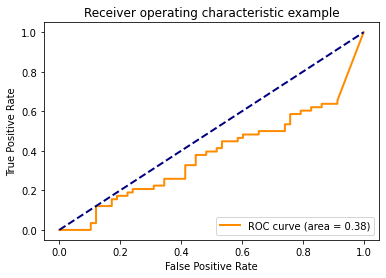

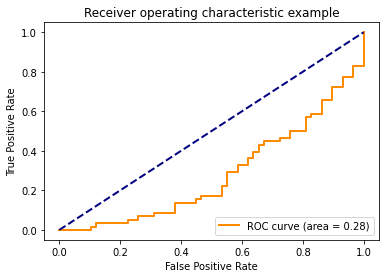

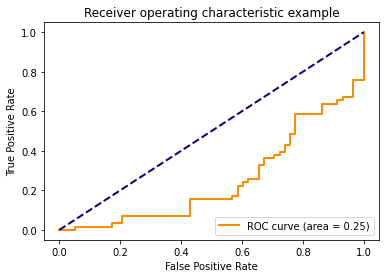

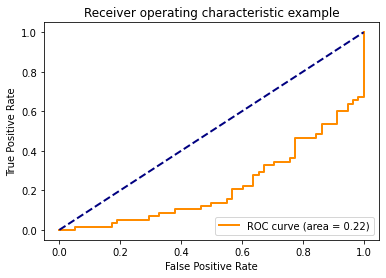

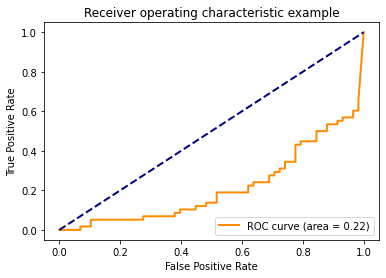

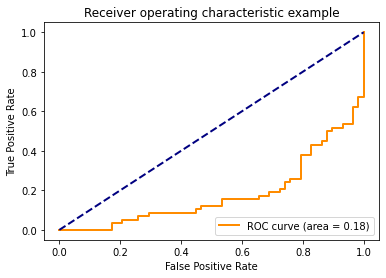

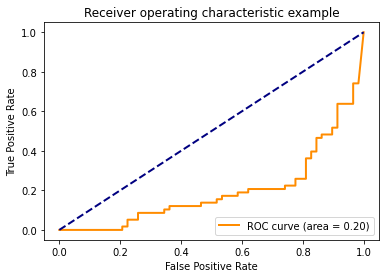

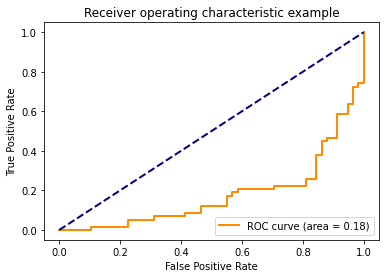

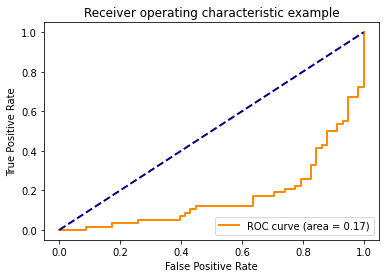

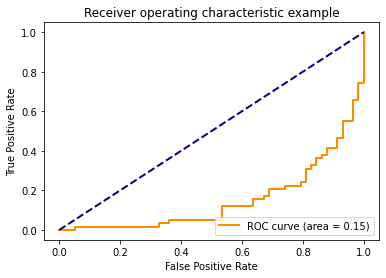

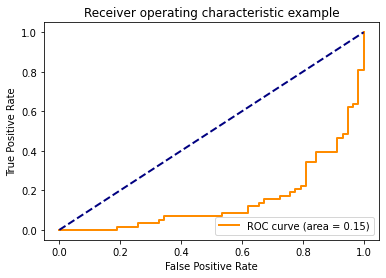

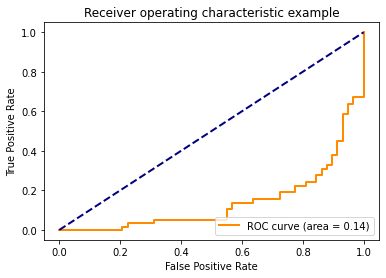

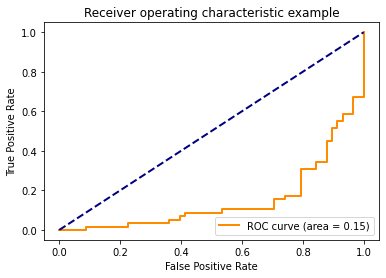

In [3]:
##########
# Usage
#   python train_grav_multi.py
##########
# ├─gravcont_250px_cross
# │   ├─train
# │   │  ├─cont
# │   │  └─grav
# │   └─val
# │       ├─cont
# │       └─grav


import os
import random
import json
import tqdm
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import folder
import torchvision.transforms as transforms
import torchvision.datasets as datasets
!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet 


# change working directory
path = '/content/drive/MyDrive/Deep_learning/666mai_dataset'
os.chdir(path)

# grav or cont, age, and sex
NUM_CLASSES = 3
# contains train, val
DATASET_PATH = r"./crossvalidation_250px/0/"
TEST_PATH = r"./crossvalidation_250px/test/"
TRAIN_FOLDER_NAME = "train"
VAL_FOLDER_NAME = "val"
EFFICIENT_NET_NAME = "efficientnet-b0"
MODEL_PATH = "./model_multi.pth"
OPTIMIZER_PATH = "./optimizer_multi.pth"
SEX_DICT_PATH = "gender_json"
AGE_DICT_PATH = "age_json"
LOG_PATH = "./log_multi.txt"
ROC_PATH = "./roc_multi.png"
CHECKPOINT_COUNT = 10
EPOCH = 100
BATCH_SIZE = 16

# transforms param
PX = 224
TRAIN_NORMALIZE_PARAM = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
TRAIN_CROP_SCALE =(0.75,1.0)
TRAIN_BRIGHTNESS_PARAM = 0.2
TRAIN_CONTRAST_PARAM = 0.1
TRAIN_SATURATION_PARAM = 0.1
TRAIN_RANDOM_ROTATION = 3
TRAIN_HUE_PARAM = 0.02
VAL_NORMALIZE_PARAM = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]

#######
# Set random seem for reproducibility
manualSeed = 1234
# print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.cuda.manual_seed(manualSeed)
#######

torch.torch.backends.cudnn.benchmark = True
torch.torch.backends.cudnn.enabled = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

age_dict = []
with open(AGE_DICT_PATH, "r") as f:
        age_dict = json.load(f)
sex_dict = []
with open(SEX_DICT_PATH, "r") as f:
        sex_dict = json.load(f)
        
class SimpleImageDataset(Dataset):
    def __init__(self, folder_path, age_dict, sex_dict, transform):
        self.transform = transform
        self.class_names = os.listdir(folder_path)
        self.item_paths = []
        self.item_dict = {}
        for class_num in range(len(self.class_names)):
                class_name = self.class_names[class_num]
                class_path = os.path.join(folder_path, class_name)
                for image_name in os.listdir(class_path):
                        base_name, ext = os.path.splitext(image_name)
                        if np.isnan(age_dict[base_name]):
                                continue
                        age = float(age_dict[base_name]) / 100
                        sex = float(sex_dict[base_name])
                        image_path = os.path.join(class_path, image_name)
                        self.item_paths.append(image_path)
                        self.item_dict[image_path] = (class_num, age, sex)

    def __len__(self):
        return len(self.item_paths)

    def __getitem__(self, idx):
        image_path = self.item_paths[idx]
        pilr_image = Image.open(image_path).convert("RGB")
        tensor_image = self.transform(pilr_image)
        class_num, age, sex = self.item_dict[image_path]
        class_num = torch.tensor(class_num)
        age = torch.tensor(age)
        sex = torch.tensor(sex)
        label = torch.tensor([class_num, age, sex])
        return tensor_image, label

if __name__ == "__main__":
        if os.path.exists(MODEL_PATH):
                model = EfficientNet.from_pretrained(EFFICIENT_NET_NAME, MODEL_PATH, num_classes=NUM_CLASSES)
        else:
                model = EfficientNet.from_pretrained(EFFICIENT_NET_NAME, num_classes=NUM_CLASSES)
        model.train()
        model.to(device)

        # transforms自体を定数として上に記述しても良いかもしれません
        train_data_transforms = transforms.Compose([
                transforms.RandomResizedCrop(PX, scale=TRAIN_CROP_SCALE),
                transforms.RandomHorizontalFlip(),
                transforms.ColorJitter(brightness=TRAIN_BRIGHTNESS_PARAM, contrast=TRAIN_CONTRAST_PARAM,
                 saturation=TRAIN_SATURATION_PARAM, hue=TRAIN_HUE_PARAM),
                # transforms.RandomRotation((-TRAIN_RANDOM_ROTATION, TRAIN_RANDOM_ROTATION)),
                transforms.ToTensor(),
                transforms.Normalize(TRAIN_NORMALIZE_PARAM[0], TRAIN_NORMALIZE_PARAM[1])])
        val_data_transforms = transforms.Compose([
                transforms.Resize(PX),
                transforms.ToTensor(),
                transforms.Normalize(VAL_NORMALIZE_PARAM[0], VAL_NORMALIZE_PARAM[1])])                
                
        train_dataset = SimpleImageDataset(os.path.join(DATASET_PATH, TRAIN_FOLDER_NAME), age_dict, sex_dict, train_data_transforms)
        train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
        print(TRAIN_FOLDER_NAME + "_dataset_size：" + str(len(train_dataset)))

        optimizer = torch.optim.AdamW(model.parameters(), 0.0002)
        if os.path.exists(OPTIMIZER_PATH):
                optimizer.load_state_dict(torch.load(OPTIMIZER_PATH))

        loss_func = torch.nn.MSELoss()
        
        val_folder_path = os.path.join(DATASET_PATH, VAL_FOLDER_NAME)
        evaluator = Evaluator(model, train_dataset.class_names, age_dict, sex_dict, val_folder_path, val_data_transforms, device)
        evaluator.draw_roc(ROC_PATH)

        for epoch in tqdm.tqdm(range(EPOCH)):
                for (i, batch) in enumerate(train_dataloader):
                        optimizer.zero_grad()

                        inputs, labels = batch
                        inputs = inputs.to(device)
                        labels = labels.to(device)
                        
                        outputs = model(inputs)

                        loss = loss_func(outputs, labels)
                        loss.backward()
                        optimizer.step()

                        if i % CHECKPOINT_COUNT == 0:
                                is_best, score = evaluator.evaluate()
                                if is_best:
                                        evaluator.draw_roc(ROC_PATH)
                                        torch.save(model.state_dict(), MODEL_PATH)
                                        torch.save(optimizer.state_dict(), OPTIMIZER_PATH)

                                # write log to file
                                with open(LOG_PATH, 'a') as f:
                                        f.write("-----")
                                        f.write("\n")
                                        f.write("batch_size: " + str(BATCH_SIZE))
                                        f.write("\n")
                                        f.write("iter: " + str(epoch * len(train_dataloader) + i))
                                        f.write(str(score))
                                        f.write("\n")
                                
                                # print log
                                print("-----")
                                print(score)
                                print("max_accuracy: " + str(evaluator.max_accuracy))




eval number of classes: 2
eval number of images: 86
initial accuracy: 0.8235294117647058
(0.82, 0.89, 0.74, 0.91, 0.81)


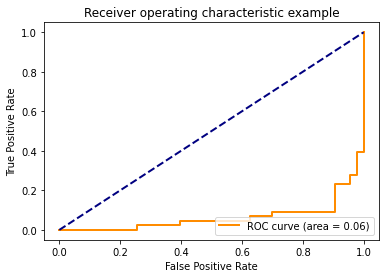

In [8]:
        #ここからevaluation (accuracy, precision, recall, specificity, f_value)                        
        model.eval()

        test_dataset = SimpleImageDataset(TEST_PATH, age_dict, sex_dict, train_data_transforms)
        test_dataloader = DataLoader(test_dataset, batch_size = 1, shuffle = False)

        test_folder_path = TEST_PATH
        evaluator = Evaluator(model, test_dataset.class_names, age_dict, sex_dict, test_folder_path, val_data_transforms, device)
        
        _ ,score =evaluator.evaluate()
        print(score)

        evaluator.draw_roc(ROC_PATH)